In [32]:
import pandas as pd
import sys
from scipy import *
from scipy import ndimage
from numpy import *
from pylab import *
from matplotlib import *
import pylab
import os 
import re



In [33]:
def density(x,y,res=100,s=3):
    xedges, yedges = linspace(x.min(), x.max(), res), linspace(y.min(), y.max(), res)
    hist, xedges, yedges = histogram2d(x, y, (xedges, yedges))
    xidx = clip(digitize(x, xedges), 0, hist.shape[0]-1)
    yidx = clip(digitize(y, yedges), 0, hist.shape[1]-1)
    hist=ndimage.filters.gaussian_filter(hist,3)
    c=hist[xidx, yidx]
    return c

In [34]:
def parseLogFile( fName ):

    fl=open(fName)
    data=[ i.split()[3:] for i in fl.readlines() if i.find("PEPTIDE_FOUND_MS1")!=-1 ]
    data=[["rt:",i[0]]+i[2:] for i in data ]
    fl.close()

    keys,idz,values=[],[],[]
    for c,s in enumerate(data[0]):
    	if( s[-1]==":"): keys.append( s )

    for s in data:
        v=[]
        for c,i in enumerate(s):
        	if( i[-1]==":"): v.append(s[c+1])
        if(len(v)==len(keys)):      values.append(v)
   
    i=[0,1,5,6,7,8,9,10,12,13,14,15,16,17,18]
    keys=[keys[j] for j in i]
    values = [[float(v[j]) for j in i] for v in values]

    peptides =  pd.DataFrame(values,columns=keys)
    peptideLengths = peptides.groupby('id:')['rt:'].max()-peptides.groupby('id:')['rt:'].min()

    peptides = peptides.loc[ peptides.groupby('id:')['intensity:'].idxmax() ]
    peptides['length:'] = peptideLengths.values

    return peptides.sort_values('rt:')

In [35]:
# plot
def plotPeptides(fp):
	m           = fp['mz:']
	me          = fp['mz_correction:']
	err         = fp['mz_window:']
	off         = fp['mz_deviation::']

	t           = fp['rt:']
	t_diff      = fp['rt_deviation:']
	t_me        = fp['rt_correction:']
	t_err       = fp['rt_window:']

	int_ratio   = array(fp['int_ratio:'])
	int_corr    = fp['int_correction:']
	lengths     = fp['length:']


	f=1.0e6
	rc('figure', figsize=(20,20))
	suptitle("%i peptides found [%s]; median length [%5.2f]"% (len(t) ,fName,median(lengths)))

	subplot(331)

	fill_between(t,(me)/m*f-err,(me)/m*f+err,color="gray",alpha=0.5)
    

	x,y=t, off/m*f
	title("Mass deviation, median=%5.2f"% (median(abs(y))) )
	scatter(x, y,c=density(x,y), marker=".",linewidth=0)
	#plot( t, off/m*f,"o",ms=3.0,color="black")
	plot( t, me/m*f ,"-",lw=1.5,color="black")
	#plot(t,t*0.0,".",lw=0.5,color="black")
	xlim([min(t)-1,max(t)+1])
	ylabel("ppm")
	xlabel("min")

    
	subplot(334)

	fill_between(t,-err,err,color="gray",alpha=0.5)
	x,y=t, (off-me)/m*f
	title("Corrected mass deviation, median=%5.2f"% (median(abs(y))) )
	scatter(x, y,c=density(x,y), marker=".",linewidth=0)
	#plot(t, (off-me)/m*f,"o",ms=3.0,color="black")
	plot( t, (me-me)/m*f ,"-",lw=1.5,color="black")
	plot(t,t*0.0,"-",lw=0.5,color="black")
	xlim([min(t)-1,max(t)+1])
	ylabel("ppm")
	xlabel("min")


	subplot(337)
	hist( array((off-me)/m*f), 25,range=(-5,5),color="gray")
	xlabel("ppm")
	xlim(-5,5)

	subplot(332)
	title("Retention time deviation, median=%5.2f"% (median(abs(t_diff))))
	fill_between(t,t_me-0.5*t_err,t_me+0.5*t_err,color="gray",alpha=0.5)
	plot(t,t*0.0,"-",lw=0.5,color="black")
	#plot(t, t_diff,"o",ms=3.0,color="black")



	scatter(t, t_diff,c=density(t,t_diff), marker=".",linewidth=0)
	plot( t, t_me ,"-",lw=1.5,color="black")

	ylabel("min")
	xlabel("min")
	#xlim([min(t)-1,max(t)+1])


	subplot(335)
	title("corrected retention time deviation, median=%5.2f"% (median(abs(t_diff-t_me))))
	fill_between(t,-0.5*t_err,0.5*t_err,color="gray",alpha=0.5)
	plot(t,t*0.0,"-",lw=0.5,color="black")

	scatter(t, t_diff-t_me,c=density(t,t_diff-t_me), marker=".",linewidth=0)
	#plot(t, t_diff-t_me,"o",ms=3.0,color="black")

	plot( t, t_me-t_me ,"-",lw=1.50,color="black")

	ylabel("min")
	xlabel("min")
	#xlim([min(t)-1,max(t)+1])

	subplot(338)
	hist( array(t_diff), 50,range=(-5,5),color="lightgray",alpha=0.5)
	hist( array(t_diff-t_me), 50,range=(-5,5),color="gray",alpha=0.5)
	xlim(-5,5)
	xlabel("min")


	subplot(333)
	int_ratio[int_ratio==0]=1.
	int_ratio=nan_to_num(int_ratio)
	x,y=t, log(int_ratio)
	
	title("intensity ratios, median=%5.2f"% (median(abs(y))))

	scatter(x, y,c=density(x,y,res=50), marker=".",linewidth=0)
	plot(t, log(1.0/int_corr),"-",lw=1.5,color="black")
	ylabel("")
	xlabel("min")


	subplot(336)

	x,y=t, log(int_ratio*int_corr)
	title("corrected intensity ratios, median=%5.2f"% (median(abs(y))))
	scatter(x, y,c=density(x,y), marker=".",linewidth=0)
	plot(t, t*0.0,"-",ms=3.0,color="gray")
	ylabel("")
	xlabel("min")

	subplot(339)
	hist( array(int_ratio*int_corr), 25,range=(0,5),color="gray")
	xlim(0,5)
	xlabel("")

In [36]:
def plotLogFile(dirName,fName,overwrite=False):

    if not re.match(r'^\d{4}_\d{8}-\d{4}.*\.txt$', fName):   
        return
    
    baseName =".".join( fName.split(".")[:-1] )
    baseName = dirName+"\\"+baseName 

    if not overwrite and os.path.exists(baseName + "_peptides.pdf"): 
        print("skipping " + baseName)
        return 

    print ( "plotting " + baseName )

    # read log file 
    fp =parseLogFile( baseName + ".txt" )

    # plot peptides
    clf()
    plotPeptides(fp)

    # save figures and peptide list 
    savefig(baseName + "_peptides.pdf")
    savefig(baseName + "_peptides.png")
    fp.to_csv(baseName + "_peptides.txt" )

plotting C:\Users\Christoph Wichmann\Documents\MaxQuant.Live\tmp\1036_20190617-2337_oldversion


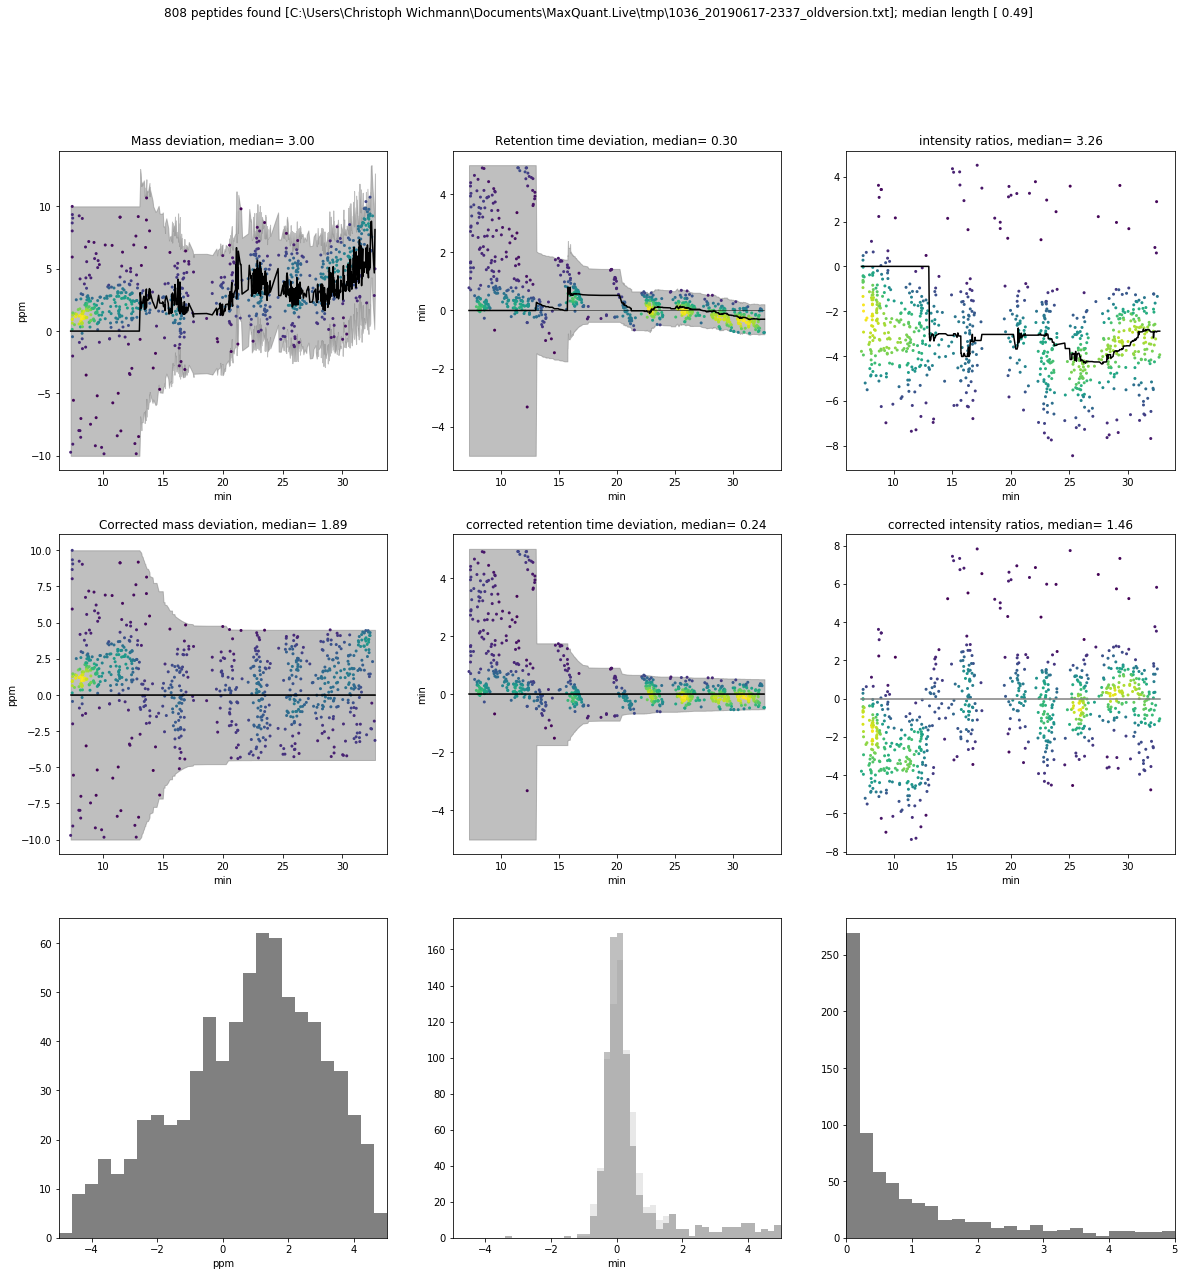

In [38]:
# plot a single file 
fName = 'C:\\Users\\Christoph Wichmann\\Documents\\MaxQuant.Live\\tmp\\1036_20190617-2337_oldversion.txt'
plotLogFile(os.path.dirname(fName), os.path.basename(fName),overwrite=True)
            
# plot all files in directory            
#logDirectory='Z:\\Users\\Sebastian\\realtimecorrection'

#for fName in os.listdir(logDirectory):
 # plotLogFile(logDirectory,fName)
        
        